# Matrix weights

In [1]:
# %%
import numpy as np
import pandas as pd
# import igraph as ig
import networkx as nx

## Consensus

### Functions

In [2]:
# %% Generate random rotation matrix
def generate_random_rotation_matrix_2d(theta, noise=0.):
    """Generate a random rotation matrix in 2d
    """
    theta_n = theta + np.random.normal(scale=noise)*np.pi
    weight = np.array([[np.cos(theta_n), -np.sin(theta_n)],
                      [np.sin(theta_n), np.cos(theta_n)]])
    
    return weight

In [3]:
def assign_rotation_matrix(src, trg):
    k, l = membership[src], membership[trg]
    if np.random.rand() < coherence:
        return com_com_rotation_matrix[(k, l)]
    else:
        if k < l:
            return generate_random_rotation_matrix_2d(theta=theta, noise=noise)
        else:
            return generate_random_rotation_matrix_2d(theta=0, noise=noise)

### Balanced case

In [4]:
# Parameters
n_nodes = 80
n_communities = 2
pin, pout = 0.3, 0.3

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities

In [5]:
g = nx.stochastic_block_model(block_sizes, pref_matrix, seed=0, directed=False)
A = nx.to_scipy_sparse_array(g)

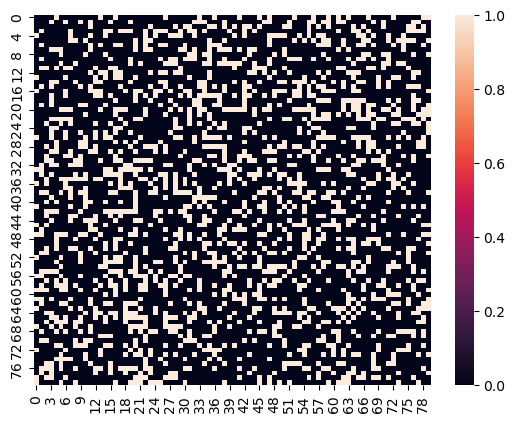

In [6]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [7]:
# Sanity check
dim = 2
theta = 2*np.pi/3

# R = generate_random_rotation_matrix_2d(np.pi/3)
# assert np.all(np.isclose(R.T @ R, np.eye(dim))), "R is not orthonormal"

In [8]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [9]:
# inital characteristic vector for nodes
# s1 - choose a random position, and assign to nodes in one community
y_0_2d = np.random.rand(dim)
y_0_2d /= np.linalg.norm(y_0_2d)
print(y_0_2d)

[0.98787623 0.15524353]


In [10]:
# randomly assign a few nodes with nonzero characteristics at t=0
from random import sample

n_sel = 15
nodes_0 = sample(range(block_sizes[0]), n_sel)

In [11]:
row = []
col = [0]*(n_sel*dim)
data = []
for k in nodes_0:
    for ki in range(dim):
        row.append(k*dim+ki)
        data.append(y_0_2d[ki])

In [12]:
from scipy.sparse import csr_array, csc_matrix
y_0 = csc_matrix((data, (row, col)), shape=(n_nodes*dim, 1))

In [13]:
# Generate a set of random rotations for each pair of communities
from scipy import sparse

src, trg, _ = sparse.find(sparse.triu(A, 1)) # only edges
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

In [14]:
theta = 2*np.pi/3
noise = 0.
com_com_rotation_matrix = {
    (k, l): generate_random_rotation_matrix_2d(theta=theta) if k < l else generate_random_rotation_matrix_2d(theta=0)
    for k in range(n_communities)
    for l in range(k, n_communities)
}

# for k in range(n_communities):
#     com_com_rotation_matrix[(k,k)] = generate_random_rotation_matrix_2d(theta=0, noise=noise)
#     for l in range(k+1, n_communities):
#             com_com_rotation_matrix[(k,l)] = generate_random_rotation_matrix_2d(theta=theta, noise=noise)

In [15]:
coherence = 1.
noise = 0.

In [16]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [17]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

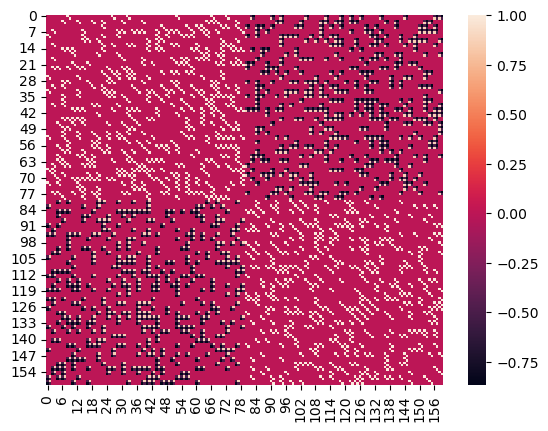

In [18]:
sns.heatmap(A_mat.todense())
plt.show()

In [19]:
# Laplacian
L_mat = D_mat - A_mat

In [20]:
# theoretical results
mat = y_0.toarray().reshape(n_nodes, 2)
y_0_bar = np.sum([assign_rotation_matrix(0, k).dot(mat[k, :]) for k in range(n_nodes)], axis=0)

y_star = []
for c in range(n_communities):
    y_star.append(com_com_rotation_matrix[(0, c)].T.dot(y_0_bar)/n_nodes)
# y_1 = com_com_rotation_matrix[(0, 0)].dot(y_0_bar)/n_nodes
# y_2 = com_com_rotation_matrix[(0, 1)].T.dot(y_0_bar)/n_nodes
print("C1:", y_star[0])
print("C2:", y_star[1])

C1: [0.18522679 0.02910816]
C2: [-0.06740499 -0.17496519]


In [21]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

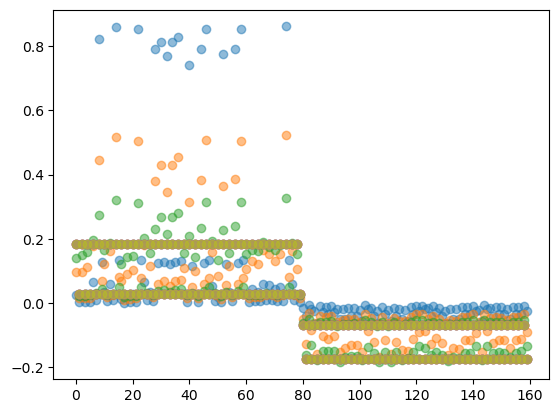

In [22]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

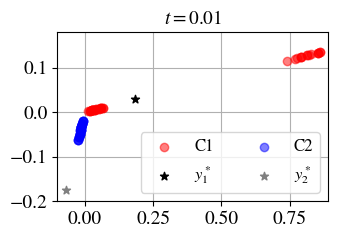

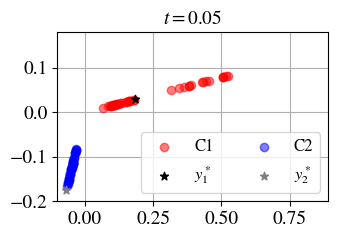

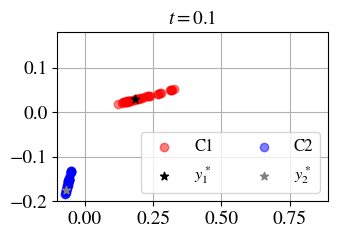

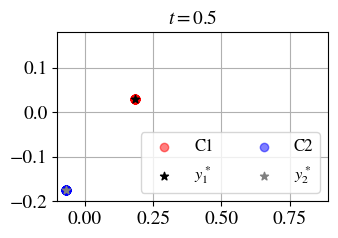

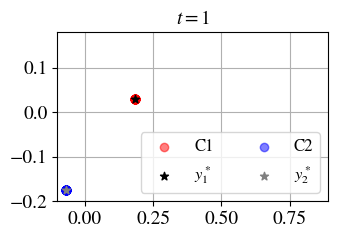

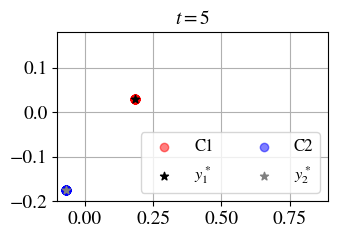

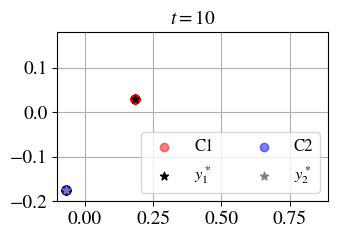

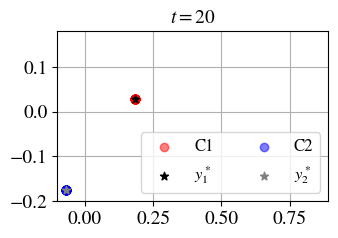

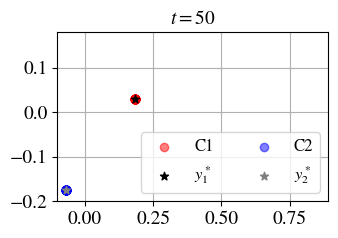

In [31]:
# scatter plot of each community
figsize = (3.6, 2.6)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

for t in range(len(ts)):
    fig, ax = plt.subplots(figsize=figsize)
    mat = res[t].toarray().reshape(n_nodes, 2)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    plt.ylim([-0.2, 0.18]) #[-0.26, 0.59]
    plt.xlim([-0.1, 0.89]) #[-0.05, 0.75]
    plt.grid()
    plt.legend(loc='lower right', ncol=2, fontsize=fz-2)
#     plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()


### Adding some noise

In [32]:
coherence = .8
noise = 0.1

In [33]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src, trg):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [34]:
# from scipy.sparse import csr_array, csc_matrix
A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

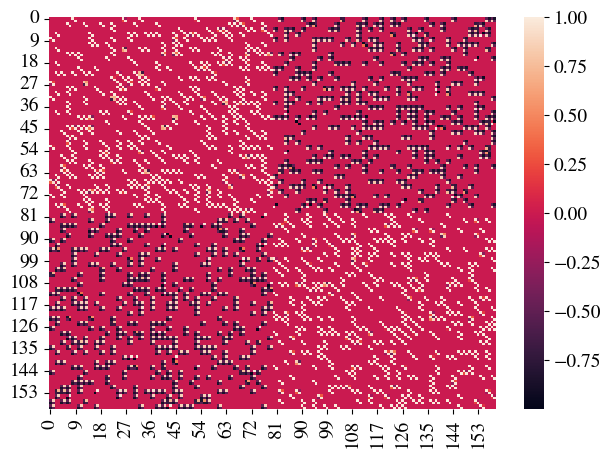

In [35]:
sns.heatmap(A_mat.todense())
plt.show()

In [36]:
# Laplacian
L_mat = D_mat - A_mat

In [37]:
# consensus dynamics
from scipy.sparse.linalg import expm

ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

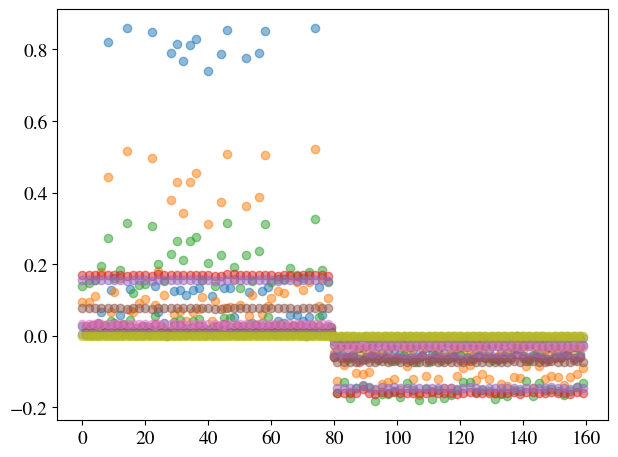

In [38]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

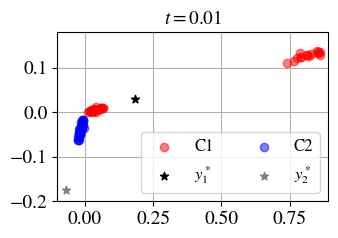

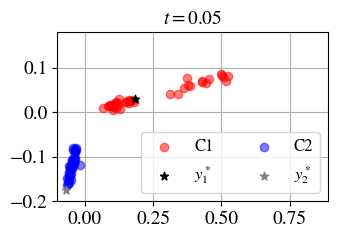

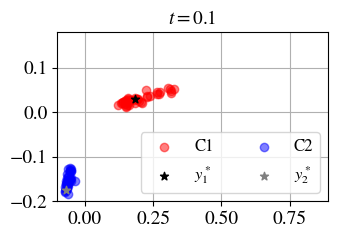

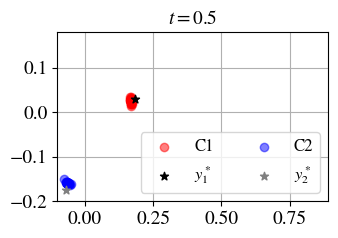

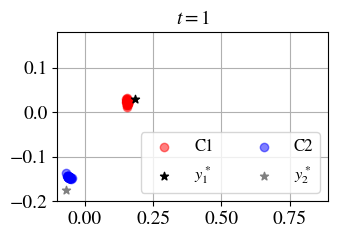

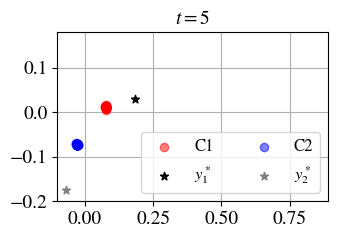

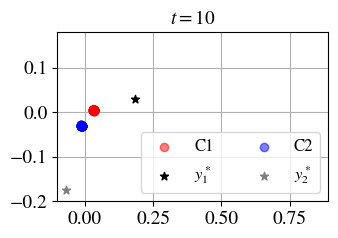

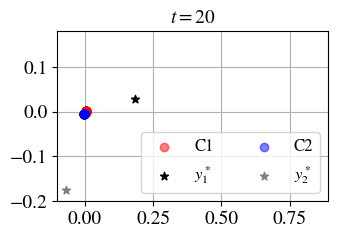

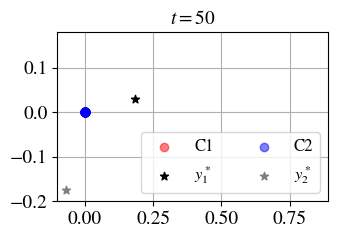

In [39]:
# scatter plot of each community
figsize = (3.6, 2.6)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

for t in range(len(ts)):
    fig, ax = plt.subplots(figsize=figsize)
    mat = res[t].toarray().reshape(n_nodes, 2)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
    plt.ylim([-0.2, 0.18]) #[-0.26, 0.59]
    plt.xlim([-0.1, 0.89]) #[-0.05, 0.75]
    plt.grid()
    plt.legend(loc='lower right', ncol=2, fontsize=fz-2)
#     plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()


### Reducing p_out

In [40]:
# randomly remove edges from g
pout2 = [0.1, 0.03, 0.01][1]
pcut = (pout - pout2)/pout
print("edges to cut:", pcut)

edges to cut: 0.9000000000000001


In [41]:
g2 = g.copy()
edges_out = [(k,l) for k,l in zip(src, trg) if membership[k] != membership[l]]
print("#edges out:", len(edges_out))
n_cut = int(len(edges_out)*pcut)
print("#edges to cut", n_cut)

#edges out: 468
#edges to cut 421


In [42]:
from random import sample

ind_cut = sample(range(len(edges_out)), n_cut)
edges_cut = [edges_out[k] for k in ind_cut]
g2.remove_edges_from(edges_cut)

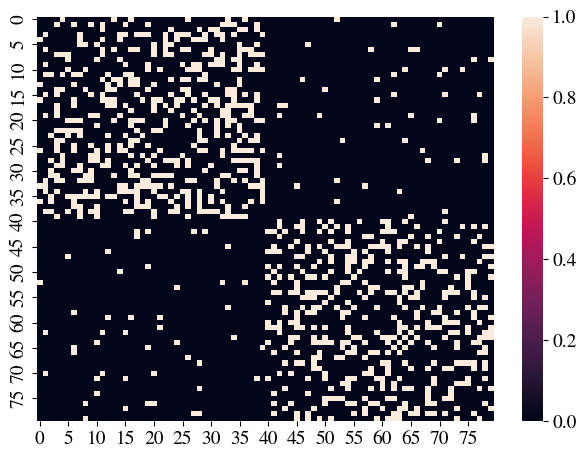

In [43]:
A = nx.to_scipy_sparse_array(g2)
sns.heatmap(A.todense())
plt.show()

In [44]:
# degree matrix
from scipy.sparse import diags

d = A.sum(axis=1)
d2 = np.repeat(d, dim)
D_mat = diags(d2, 0, format='csc')

In [45]:
src2, trg2, _ = sparse.find(sparse.triu(A, 1)) # only edges

In [46]:
coherence = .8
noise = 0.1

In [47]:
# construct the block weight matrix
row = []
col = []
data = []
for k, l in zip(src2, trg2):
    rot = assign_rotation_matrix(k, l)
    # assign the correct index
    for ki in range(dim):
        for li in range(dim):
            # direction kl
            row.append(k*dim+ki)
            col.append(l*dim+li)
            data.append(rot[ki, li])
            # direction lk
            row.append(l*dim+li)
            col.append(k*dim+ki)
            data.append(rot[ki,li])

In [48]:
from scipy.sparse import csr_array, csc_matrix

A_mat = csc_matrix((data, (row, col)), shape=(n_nodes*dim, n_nodes*dim))

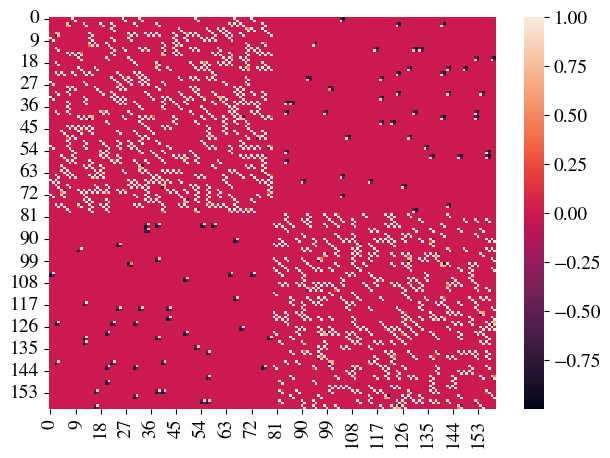

In [49]:
sns.heatmap(A_mat.todense())
plt.show()

In [50]:
# Laplacian
L_mat = D_mat - A_mat

In [51]:
# consensus dynamics
from scipy.sparse.linalg import expm

# ts = [0.01, 0.05, 0.1, 0.5, 1]
ts = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 20, 50]
res = []

for t in ts:
    res.append(expm(- L_mat*t) @ y_0)

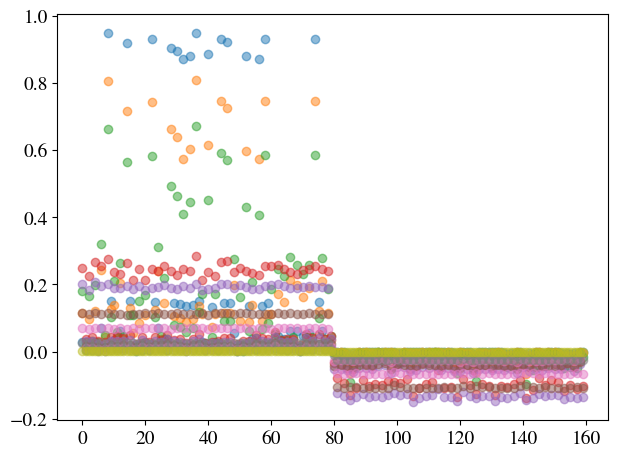

In [52]:
# output the results
for t in range(len(ts)):
    plt.scatter(range(n_nodes*dim), res[t].toarray()[:, 0], alpha=0.5)
plt.show()

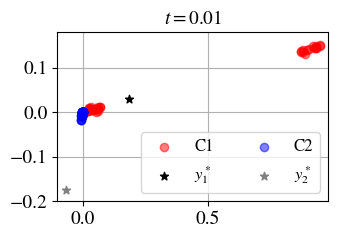

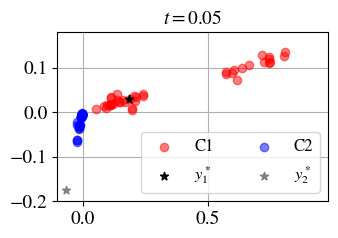

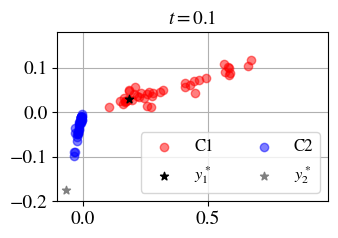

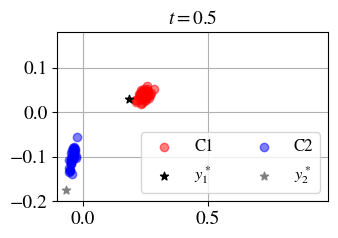

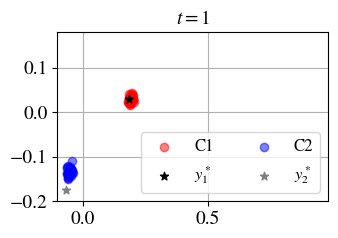

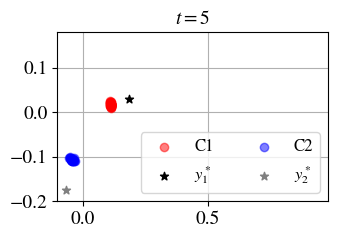

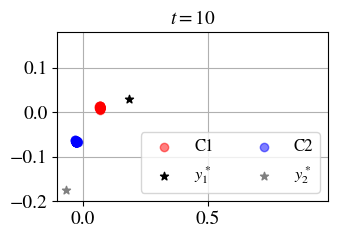

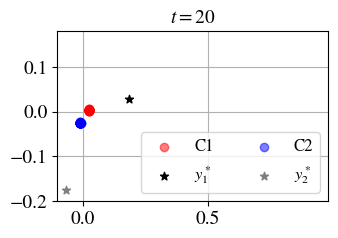

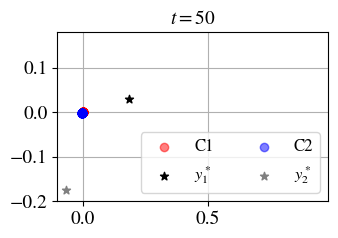

In [57]:
# scatter plot of each community
figsize = (3.6, 2.6)
alpha = 0.5
colors = ['r', 'b']
colors_m = ['k', 'grey']
labels = ['C1', 'C2']

fz = 14
plt.rcParams.update({'font.size': fz,
                        'figure.autolayout': True,
                        'axes.titlesize': fz,
                        'axes.labelsize': fz,
                        'legend.fontsize': fz,
                        'mathtext.fontset': 'stix',
                        'font.family': 'STIXGeneral'})

for t in range(len(ts)):
    fig, ax = plt.subplots(figsize=figsize)
    mat = res[t].toarray().reshape(n_nodes, 2)
    ci = 0
    for c in range(len(block_sizes)):
        ax.scatter(mat[ci:ci+block_sizes[c], 0], mat[ci:ci+block_sizes[c], 1], color=colors[c], label=labels[c], alpha=alpha)
        ax.scatter(y_star[c][0], y_star[c][1], marker='*', color=colors_m[c], label=r'$y_{}^*$'.format(c+1))
        ci += block_sizes[c]
    ax.set_axisbelow(True)
    ax.set_title(r'$t={}$'.format(ts[t]))
#     plt.ylim([-0.2, 0.18]) #[-0.26, 0.59]
#     plt.xlim([-0.1, 0.89]) #[-0.05, 0.75]
    plt.ylim([-0.2, 0.18]) #[-0.26, 0.62]
    plt.xlim([-0.1, 0.98]) # [-0.05, 0.78]
    plt.grid()
    plt.legend(loc='lower right', ncol=2, fontsize=fz-2)
#     plt.savefig('consensus-SBM-d{}-po{}-co{}-t{}.png'.format(dim, pout2, coherence, t), dpi=300, bbox_inches='tight')
    plt.show()


## Random walks

In [ ]:
# Parameters
n_nodes = 120
n_communities = 3
pin, pout = 0.3, 0.01
dim = 10
walk_length = 1000
coherence = 0.2

assert n_nodes % n_communities == 0, "n_nodes must be divisible by n_communities"

# Generate a base network using the stochastic block model
pref_matrix = np.full((n_communities, n_communities), pout)
pref_matrix[np.diag_indices_from(pref_matrix)] = pin
block_sizes = [n_nodes // n_communities] * n_communities
# g = ig.Graph.SBM(
#     n_nodes,
#     pref_matrix,
#     block_sizes=block_sizes,
#     directed=False,
# )
# A = g.get_adjacency_sparse()

In [ ]:
# %% Plot the network
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(A.todense())
plt.show()

In [ ]:
# %% Generate random rotation matrix
def generate_random_rotation_matrix(sz):
    """Generate a random rotation matrix of size sz x sz using Householder reflections
    Efficient Orthogonal Parametrisation of Recurrent Neural Networks Using Householder Reflections
    Mhammedi et al. arxiv
    """
    weight = np.random.randn((sz * (sz + 1)) // 2)

    def rotate_by_householder(v, weight):
        get_uk = lambda k: weight[
            (k * (k + 1)) // 2 : (k * (k + 1)) // 2 + k + 1
        ].reshape(-1, 1)

        def apply_householder(v, uk):
            k = len(uk)
            v[-k:] = v[-k:] - 2 * (uk.T @ v[-k:]) * uk / np.linalg.norm(uk) ** 2
            return v

        for k in range(1, sz):
            uk = get_uk(k)
            v = apply_householder(v, uk)
        return v

    # Create an identity matrix
    return rotate_by_householder(np.eye(sz), weight)


In [ ]:
# Sanity check
R = generate_random_rotation_matrix(dim)
assert np.all(np.isclose(R.T @ R, np.eye(dim))), "R is not orthonormal"

In [ ]:
# Generate a set of random rotations for each pair of communities
from scipy import sparse

src, trg, _ = sparse.find(sparse.triu(A, 1))
membership = np.digitize(np.arange(n_nodes), np.cumsum(block_sizes))

com_com_rotation_matrix = {
    (k, l): generate_random_rotation_matrix(dim)
    for k in range(n_communities)
    for l in range(n_communities)
}

In [ ]:
def assign_rotation_matrix(src, trg):
    k, l = membership[src], membership[trg]
    if np.random.rand() < coherence:
        if k != l:
            return com_com_rotation_matrix[(k, l)]
        else:
            return np.eye(dim)
    else:
        return generate_random_rotation_matrix(dim)


In [ ]:
RotationMatrix = {(k, l): assign_rotation_matrix(k, l) for k, l in zip(src, trg)}

In [ ]:
# %% Generate the random walk sequence
import numba


def random_walk(A, n_steps, initial_node):
    @numba.njit
    def _random_walk(indptr, indices, n_steps, initial_node):
        current_node = initial_node
        traj = np.zeros(n_steps, dtype=np.int32)
        for i in range(n_steps):
            neighbors = indices[indptr[current_node] : indptr[current_node + 1]]
            current_node = np.random.choice(neighbors)
            traj[i] = current_node

        return traj

    return _random_walk(A.indptr, A.indices, n_steps, initial_node)


node_seq = random_walk(A, walk_length, np.random.randint(n_nodes))

In [ ]:
# %% Compute the trajectory of the walker in the state space

# Initial random walk position
x_pos = np.random.randn(dim)
x_pos = x_pos / np.linalg.norm(x_pos)

# Convert from the node-level trajectory to the community-level trajectory
traj = [x_pos.copy()]
for i in range(walk_length - 1):
    src, trg = node_seq[i], node_seq[i + 1]
    if src <= trg:
        R = RotationMatrix[(src, trg)]
    else:
        R = RotationMatrix[(trg, src)]
        R = R.T
    x_pos = R @ x_pos
    x_pos = x_pos / np.linalg.norm(x_pos)
    traj.append(x_pos.copy())

traj = np.vstack(traj)

In [ ]:
# %% Similarity matrix between the trajectory
# %%
sns.set_style('white')
sns.set(font_scale=1.2)
sns.set_style('ticks')
cmap = sns.color_palette("colorblind").as_hex()
row_colors = [cmap[membership[i]] for i in node_seq]
col_colors = [cmap[membership[i]] for i in node_seq]

g = sns.clustermap(
    traj @ traj.T,
    cmap="coolwarm",
    center=0,
    figsize=(7, 7),
    row_colors=row_colors,
    col_colors=col_colors,
    row_cluster=False,
    col_cluster=False,
    vmin=-1,
    vmax=1,
    cbar_pos=(0, 0.2, 0.03, 0.4),
)

# Add colorbar label
cbar = g.ax_heatmap.collections[0].colorbar
cbar.set_label("Correlation", rotation=90, labelpad=15)

g.fig.tight_layout()
g.fig.show()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

cmap = sns.color_palette("colorblind")

com_seq = membership[node_seq]
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
xy = PCA(n_components=2).fit_transform(traj)
sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=com_seq, palette=cmap, ax=axes[0])
# Add trajectory lines to PCA plot
for i in range(len(xy) - 1):
    axes[0].plot(
        xy[i : i + 2, 0], xy[i : i + 2, 1], color="gray", alpha=0.5, linewidth=0.5
    )

# Add an arrow to show the direction
arrow_start = xy[-2]
arrow_end = xy[-1]
axes[0].annotate(
    "",
    xy=arrow_end,
    xytext=arrow_start,
    arrowprops=dict(arrowstyle="->", color="red", lw=2),
)


xy = TSNE(n_components=2).fit_transform(traj)

sns.scatterplot(x=xy[:, 0], y=xy[:, 1], hue=com_seq, palette=cmap, ax=axes[1])
for i in range(len(xy) - 1):
    axes[1].plot(
        xy[i : i + 2, 0], xy[i : i + 2, 1], color="gray", alpha=0.5, linewidth=0.5
    )
plt.tight_layout()

axes[0].set_title("PCA")
axes[1].set_title("t-SNE")
axes[0].axis("off")
axes[1].axis("off")